In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wrangle_fitbit as wf
import seaborn as sns
import csv
from sklearn import metrics
from math import sqrt

### Planning and Initial Hypothesis

##### Initial Hypothesis: This person was inactive until July and then started some sort of exercise program

#### Goal

Improve model to predict calories burned, steps, and active calories burned in the future.

Make discoveries about the person this device belongs to.


#### Planning and initial exploration

Discussed possible drivers of calories burned and steps (weekday vs weekend, uptick over time, etc)

Graphed all available data in boxplots by day of week.



In [2]:
df = wf.get_activities_data(splain=True)

DATAFRAME SHAPE:
(225, 16)

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 16 columns):
cals_burned          225 non-null float64
steps                225 non-null float64
dist                 225 non-null float64
flrs                 225 non-null float64
mins_sed             225 non-null float64
mins_light           225 non-null float64
mins_mod             225 non-null float64
mins_heavy           225 non-null float64
activity_cals        225 non-null float64
mins_tot             225 non-null float64
mins_off             225 non-null float64
week_day             225 non-null object
cals_idle            225 non-null float64
mins_idle            225 non-null float64
idle_cals_per_min    225 non-null float64
daily_rest_cals      225 non-null float64
dtypes: float64(15), object(1)
memory usage: 29.9+ KB
None

DATAFRAME DESCRIPTION:
                   count         mean          std         min          25%  \

In [3]:
df.head()

,cals_burned,steps,dist,flrs,mins_sed,mins_light,mins_mod,mins_heavy,activity_cals,mins_tot,mins_off,week_day,cals_idle,mins_idle,idle_cals_per_min,daily_rest_cals
date,,,,,,,,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0,1440.0,0.0,4-Thu,2069.0,1347.0,1.536006,2211.848552
2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0,1440.0,0.0,5-Fri,1897.0,1158.0,1.638169,2358.963731
2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0,890.0,550.0,6-Sat,2255.0,1252.0,1.801118,2593.610224
2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0,1013.0,427.0,0-Sun,2249.0,1318.0,1.706373,2457.177542
2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0,984.0,456.0,1-Mon,2285.0,1336.0,1.710329,2462.874251


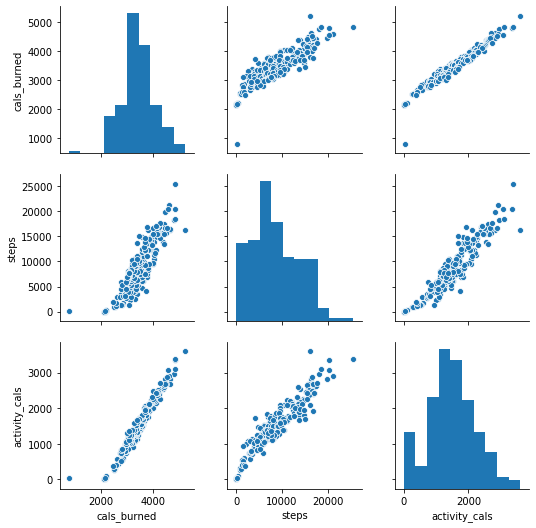

In [8]:
sns.pairplot(df[['cals_burned','steps','activity_cals']])

### Floors: Major outliers in the increased-activity segment

Floors spikes 9 times, suggesting there is either a stress-test, climb, bike ride, or some other unusual activity involving high increases in elevation. The heatmap does not reveal a direct correlation between floors and any other variable, suggesting that the elevation-changing activity is a transplanting some other elevated activity that would otherwise occur.

To investigate further, we've pulled these 9 dates:

In [9]:
df[df.flrs >= 50]

,cals_burned,steps,dist,flrs,mins_sed,mins_light,mins_mod,mins_heavy,activity_cals,mins_tot,mins_off,week_day,cals_idle,mins_idle,idle_cals_per_min,daily_rest_cals
date,,,,,,,,,,,,,,,,
2018-08-04,4376.0,17126.0,8.08,78.0,585.0,206.0,17.0,124.0,2584.0,932.0,508.0,6-Sat,1792.0,1093.0,1.639524,2360.914913
2018-09-15,3180.0,9445.0,4.45,77.0,849.0,134.0,23.0,51.0,1287.0,1057.0,383.0,6-Sat,1893.0,1232.0,1.536526,2212.597403
2018-09-16,3344.0,9015.0,4.25,102.0,586.0,184.0,30.0,38.0,1494.0,838.0,602.0,0-Sun,1850.0,1188.0,1.557239,2242.424242
2018-10-05,3603.0,11029.0,5.20,105.0,822.0,167.0,7.0,71.0,1684.0,1067.0,373.0,5-Fri,1919.0,1195.0,1.605858,2312.435146
2018-10-10,3183.0,8996.0,4.24,128.0,683.0,151.0,18.0,48.0,1330.0,900.0,540.0,3-Wed,1853.0,1223.0,1.515127,2181.782502
2018-10-16,3432.0,11061.0,5.22,162.0,819.0,229.0,8.0,55.0,1630.0,1111.0,329.0,2-Tue,1802.0,1148.0,1.569686,2260.348432
2018-11-11,4264.0,17761.0,8.36,129.0,486.0,299.0,47.0,76.0,2717.0,908.0,532.0,0-Sun,1547.0,1018.0,1.519646,2188.290766
2018-11-22,4494.0,16705.0,7.84,177.0,522.0,284.0,18.0,115.0,2868.0,939.0,501.0,4-Thu,1626.0,1023.0,1.589443,2288.797654
2018-12-02,3957.0,13257.0,6.23,195.0,725.0,265.0,13.0,70.0,2305.0,1073.0,367.0,0-Sun,1652.0,1092.0,1.512821,2178.461538


What we found was more confusing than not. One would expect changing elevation from 750 to 2000 feet would require more than light exertion, however the moderate and heavy values do not support such an increase. The only conceivable way these values match up is if the elevation change occured during times of light activity, such as a non-brisk walk.

That, or the fitbit was faulty.

In [10]:
def all_box_plots(df, x_col='week_day'):
    new_df = df.copy()
    new_df = new_df.sort_values(by=x_col)
    for col in df_limit_numerics(df).columns:
        
        plt.figure(figsize=(7,5))
        sns.boxplot(data=new_df,x=x_col,y=col,showmeans=True)

        plt.hlines(df[col].mean(),0,6, color='blue')
        plt
        plt.ylabel(col)
        plt.show()

In [14]:
all_box_plots(df[['cals_burned','steps','dist','activity_cals','week_day']],x_col='week_day')

NameError: name 'df_limit_numerics' is not defined

In [11]:
df.head(2)

,cals_burned,steps,dist,flrs,mins_sed,mins_light,mins_mod,mins_heavy,activity_cals,mins_tot,mins_off,week_day,cals_idle,mins_idle,idle_cals_per_min,daily_rest_cals
date,,,,,,,,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0,1440.0,0.0,4-Thu,2069.0,1347.0,1.536006,2211.848552
2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0,1440.0,0.0,5-Fri,1897.0,1158.0,1.638169,2358.963731
